##  Imports

In [257]:
import sys
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

!{sys.executable} -m pip install chardet
import chardet

- [Fase 2](#Fase-2)
- [Fase 3](#Fase-3)
- [Fase 4](#Fase-4)
- [Relatório](#Relatório)

<a id="Funções"></a>

### Funções Auxiliares

In [258]:
def find_outliers_tucker(series, threshold=1.5):
    """
    Retorna os índices dos valores obtidos como outliers após calculados os limites superiores
    e inferiores da Series em questão, utilizando o algoritmo de Tucker.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    lower_limit = q1 - threshold * iqr
    upper_limit = q3 + threshold * iqr

    filtered_series = series[(series < lower_limit) | (series > upper_limit)]
    
    return filtered_series.index

def imputa_rua(bairro, df):
    return df[bairro]

def imputa_bairro(rua, df):
    rua_formatted = rua.split(',')[0]
    imoveis = df.loc[df['Rua'] == rua_formatted]

    if imoveis.shape[0] == 0:
        bairro = None
    else:
        bairro = imoveis['Bairro'].unique()[0]

    return bairro

def jupyter_settings():
    %matplotlib inline
    warnings.filterwarnings('ignore')

    plt.rcParams['figure.figsize'] = (24, 12)
    plt.rcParams['font.size'] = 24
    pd.set_option('display.float_format', '{:.2f}'.format)
    pd.set_option('display.max_columns', 100)

    sns.set()

jupyter_settings()

### Carregando os Dados

Carregando **dataset de imóveis** à venda na cidade de São Paulo

In [259]:
df_imoveis = pd.read_csv('./dados/dados_imoveis.csv')
df_imoveis.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000


<a id="Fase-2"></a>

# FASE 2
___

## Descrição dos Dados

In [260]:
df1_imoveis = df_imoveis.copy()

In [261]:
print('Número de linhas: ', df1_imoveis.shape[0])
print('Número de colunas: ', df1_imoveis.shape[1])

Número de linhas:  10008
Número de colunas:  8


In [262]:
df1_imoveis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rua        6574 non-null   object
 1   Bairro     9996 non-null   object
 2   Cidade     10008 non-null  object
 3   Metragem   10008 non-null  int64 
 4   Quartos    10008 non-null  int64 
 5   Banheiros  10008 non-null  int64 
 6   Vagas      10008 non-null  int64 
 7   Valor      10008 non-null  object
dtypes: int64(4), object(4)
memory usage: 625.6+ KB


### Tipos dos Dados

In [263]:
df1_imoveis.dtypes

Rua          object
Bairro       object
Cidade       object
Metragem      int64
Quartos       int64
Banheiros     int64
Vagas         int64
Valor        object
dtype: object

O tipo da coluna `Valor` está errado, devendo ser transformada para numérica. Escolhemos transformá-la para int64, o que será feito mais a frente.

### Valores Nulos

In [264]:
df1_imoveis.isna().sum()

Rua          3434
Bairro         12
Cidade          0
Metragem        0
Quartos         0
Banheiros       0
Vagas           0
Valor           0
dtype: int64

As variáveis `Rua` e `Bairro` possuem valores nulos que precisam ser tratados posteriormente.

### Buscando Variáveis com Tipos de Dados Incorretos

**Variável `Valor`**

Analisando os valores desta coluna descobrimos que ela não somente mostra o valor absoluto das casas, mas para algumas linhas ela mostra o valor do aluguel, podendo este ser diário, mensal ou anual.

Aluguel Diário

In [265]:
df1_imoveis[df1_imoveis['Valor'].str.contains('Dia')]

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
6639,NaN,Jardim Guedala,São Paulo,572,4,6,7,R$ 15.000\r\n /Dia
7421,NaN,Jardim Guedala,São Paulo,577,4,6,7,R$ 15.000\r\n /Dia


Aluguel Mensal

In [266]:
df_imoveis_alugar = df1_imoveis[df1_imoveis['Valor'].str.contains('Mês')]
df_imoveis_alugar.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
151,Rua Fonseca da Costa,Bosque da Saúde,São Paulo,650,4,6,12,R$ 11.000\r\n /Mês
156,NaN,Jardim Paulistano,São Paulo,230,2,3,2,R$ 12.000\r\n /Mês
175,Rua Maestro Elias Lobo,Jardim Paulista,São Paulo,542,5,8,4,R$ 25.000\r\n /Mês
178,Rua Guararapes,Lapa,São Paulo,515,3,5,8,R$ 30.000\r\n /Mês
182,Rua Alvarenga,Butantã,São Paulo,400,4,3,4,R$ 10.000\r\n /Mês


Aluguel Anual

In [267]:
df1_imoveis[df1_imoveis['Valor'].str.contains('Ano')]

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
6029,NaN,Instituto de Previdência,São Paulo,120,3,1,2,R$ 2.600\r\n /Ano
6718,NaN,Instituto de Previdência,São Paulo,125,3,1,2,R$ 2.600\r\n /Ano


### Deletando esses imóveis:

In [268]:
# Deletando os imóveis de aluguel DIÁRIO
df1_imoveis.drop(df1_imoveis[df1_imoveis['Valor'].str.contains('Dia')].index, inplace=True)

# Deletando e salvando os imóveis de aluguel MENSAL
df1_imoveis.drop(df_imoveis_alugar.index, inplace=True)
df_imoveis_alugar.to_csv('./dados/dados_imoveis_alugar.csv')

# Deletando os imóveis de aluguel ANUAL
df1_imoveis.drop(df1_imoveis[df1_imoveis['Valor'].str.contains('Ano')].index, inplace=True)

**Resolvendo o tipo incorreto**

In [269]:
df1_imoveis['Valor'].sample(5)

8677       R$ 622.500
8393    R$ 19.000.000
7450     R$ 9.000.000
3458     R$ 1.450.000
9990     R$ 2.450.000
Name: Valor, dtype: object

Corrigindo o tipo de dado da variável `Valor`

In [270]:
# Casting da variável Valor de Object para int64
df1_imoveis['Valor'] = df1_imoveis['Valor']\
    .str.replace('R\$|,', '', regex=True)\
        .str.replace('.', '').str.strip()

In [271]:
df1_imoveis['Valor'] = df1_imoveis['Valor'].astype(int)
df1_imoveis['Valor'].sample(5)

df1_relatorio = df1_imoveis.copy()

## Criando Novas Colunas 

In [272]:
df2_imoveis = df1_imoveis.copy()

#### Criando a coluna `Valor_m2`

Representa o valor médio do m2 para cada linha do dataframe.

In [273]:
df2_imoveis['Valor_m2'] = df2_imoveis['Valor'] / df2_imoveis['Metragem']
df2_imoveis['Valor_m2'].head()

0   7000.00
1   7459.68
2   3040.00
3   2209.68
4   5400.00
Name: Valor_m2, dtype: float64

## Estatísticas de Resumo

In [274]:
df3_imoveis = df2_imoveis.copy()

In [275]:
# dividindo o dataframe em variáveis numéricas e categóricas
num_attr, cat_attr = df3_imoveis.select_dtypes(include=[int, float]), df3_imoveis.select_dtypes(exclude=[int, float])

**Variáveis Numéricas**

In [276]:
num_attr.describe().rename({'count': 'Quantidade', 'max': 'Máximo', 'min': 'Mínimo', '50%': 'Mediana/Q2', 'mean': 'Média', '25%': 'Q1', '75%': 'Q3', 'std': 'Desvio Padrão'}).T

,Quantidade,Média,Desvio Padrão,Mínimo,Q1,Mediana/Q2,Q3,Máximo
Metragem,9156.00,434.42,7856.42,10.00,168.00,276.00,450.00,750000.00
Quartos,9156.00,3.45,1.05,1.00,3.00,3.00,4.00,16.00
Banheiros,9156.00,3.80,1.97,1.00,2.00,4.00,5.00,40.00
Vagas,9156.00,3.96,2.60,1.00,2.00,4.00,5.00,50.00
Valor,9156.00,3052202.96,3944208.19,13000.00,890000.00,1800000.00,3500000.00,65000000.00
Valor_m2,9156.00,8004.07,5291.32,9.33,4750.00,6500.00,9453.78,80000.00


Imprimindo boxplot para as variáveis numéricas

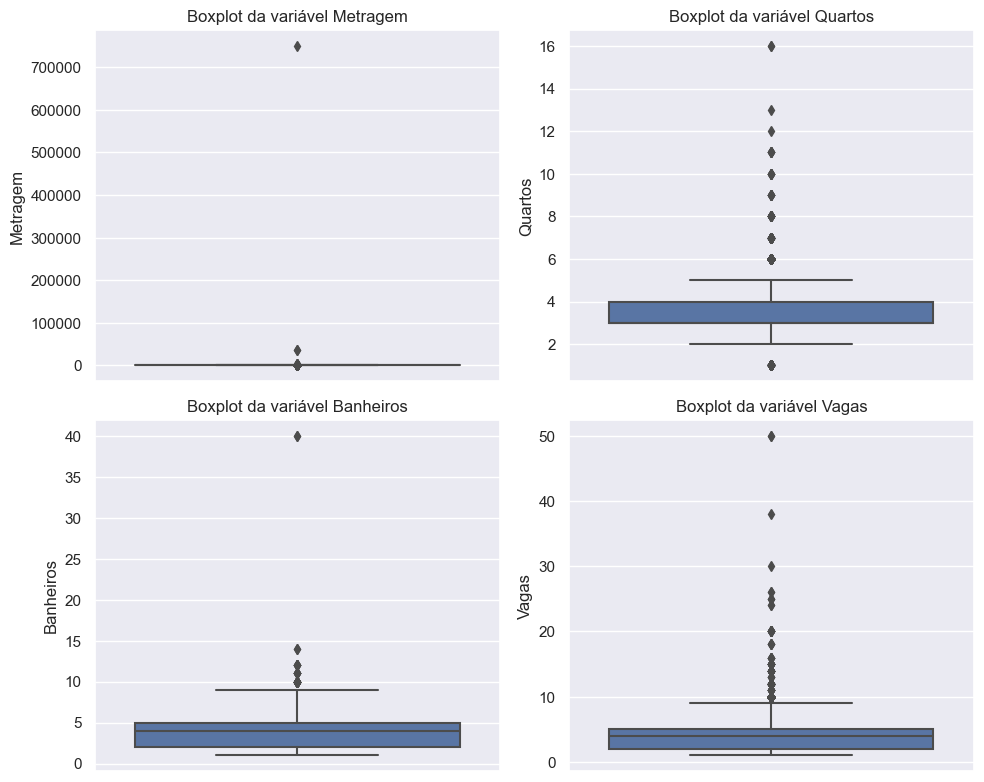

In [277]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Boxplot da variável Metragem
sns.boxplot(data=df3_imoveis, y='Metragem', ax=ax[0, 0])
ax[0, 0].set_title('Boxplot da variável Metragem')

# Boxplot da variável Quartos
sns.boxplot(data=df3_imoveis, y='Quartos', ax=ax[0, 1])
ax[0, 1].set_title('Boxplot da variável Quartos')

# Boxplot da variável Banheiros
sns.boxplot(data=df3_imoveis, y='Banheiros', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot da variável Banheiros')

# Boxplot da variável Vagas
sns.boxplot(data=df3_imoveis, y='Vagas', ax=ax[1, 1])
ax[1, 1].set_title('Boxplot da variável Vagas')

plt.tight_layout()

plt.show()

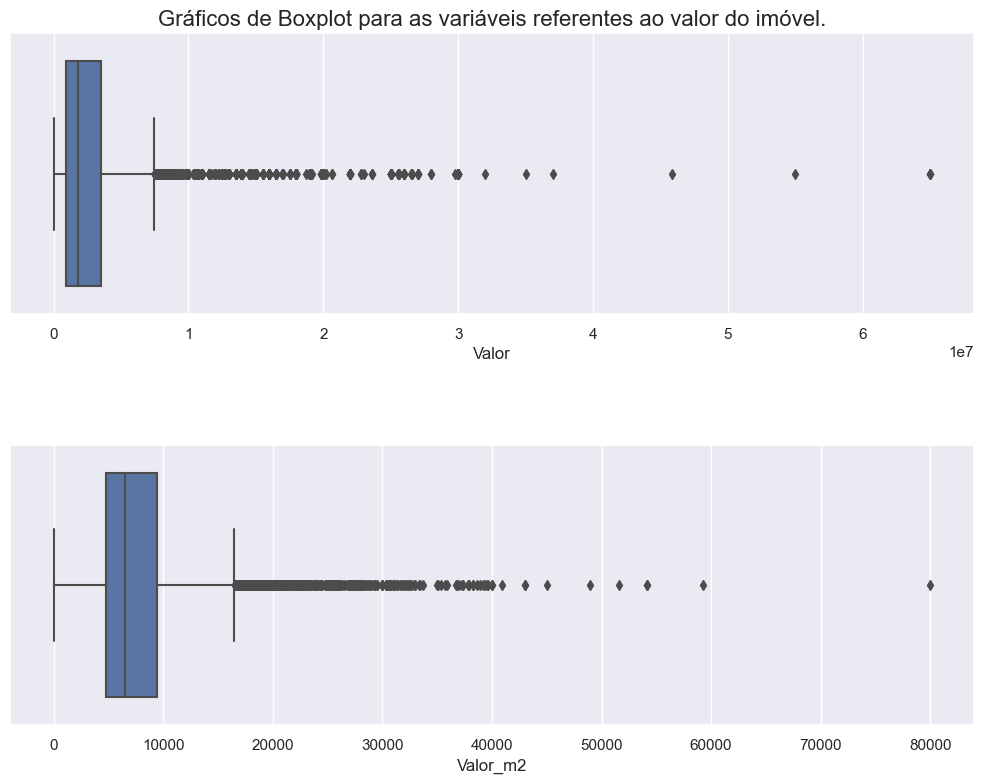

In [278]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.boxplot(data=df3_imoveis, x='Valor', ax=ax[0])

sns.boxplot(data=df3_imoveis, x='Valor_m2', ax=ax[1])

ax[0].set_title('Gráficos de Boxplot para as variáveis referentes ao valor do imóvel.', fontsize = 16)
plt.tight_layout(h_pad = 5)

plt.show()

OBS: Os boxplots mostrados acima estão tratados na seção do relatório

**Variáveis Categóricas**

In [279]:
cat_attr.describe().rename({'count': 'Quantidade', 'unique': 'Qtd. Valores Únicos', 'top': 'Moda', 'freq': 'Freq. da Moda'}).T

,Quantidade,Qtd. Valores Únicos,Moda,Freq. da Moda
Rua,6107,3006,Rua Alberto Faria,24
Bairro,9146,697,Alto de Pinheiros,369
Cidade,9156,1,São Paulo,9156


<a id="Fase-3"></a>

# FASE 3
___

## Análise Exploratória dos Dados

In [280]:
df4_imoveis = df3_imoveis.copy()

### Análise Univariada

##### Variáveis Numéricas

##### `Metragem`

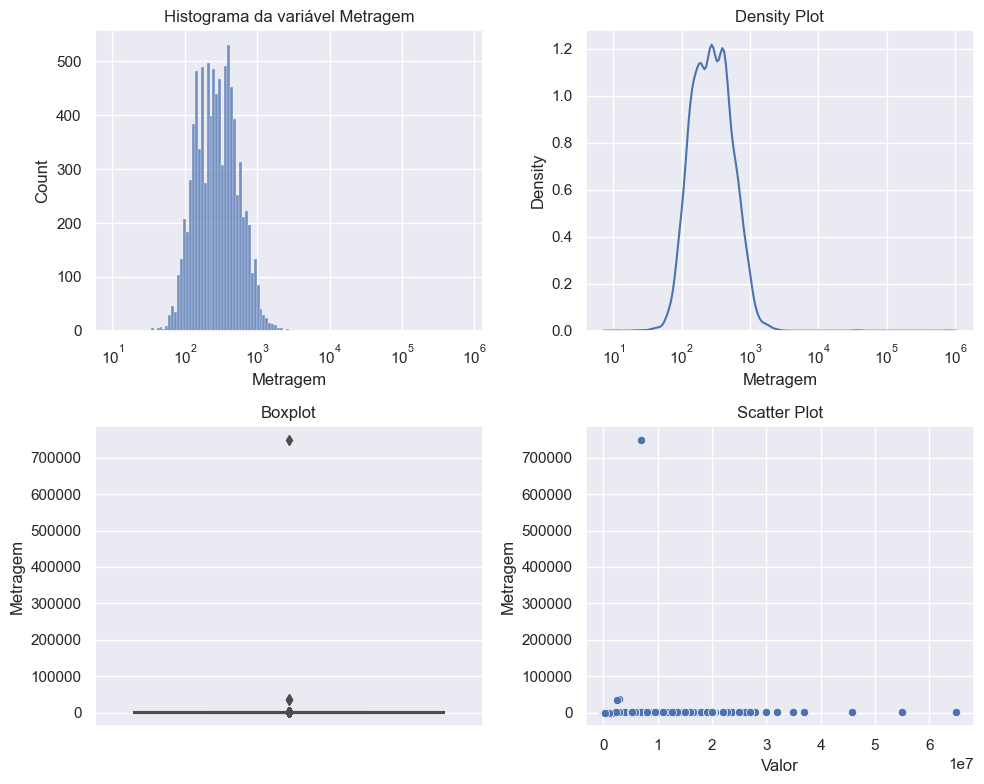

In [281]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.histplot(data=df4_imoveis, x='Metragem', ax=ax[0, 0], log_scale=True)#, kde = True, log_scale = True, bins = 25)
ax[0, 0].set_title('Histograma da variável Metragem')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Metragem', ax=ax[0, 1], log_scale=True)
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Metragem', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Metragem', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Quartos`

Imprimindo gráficos elucidativos

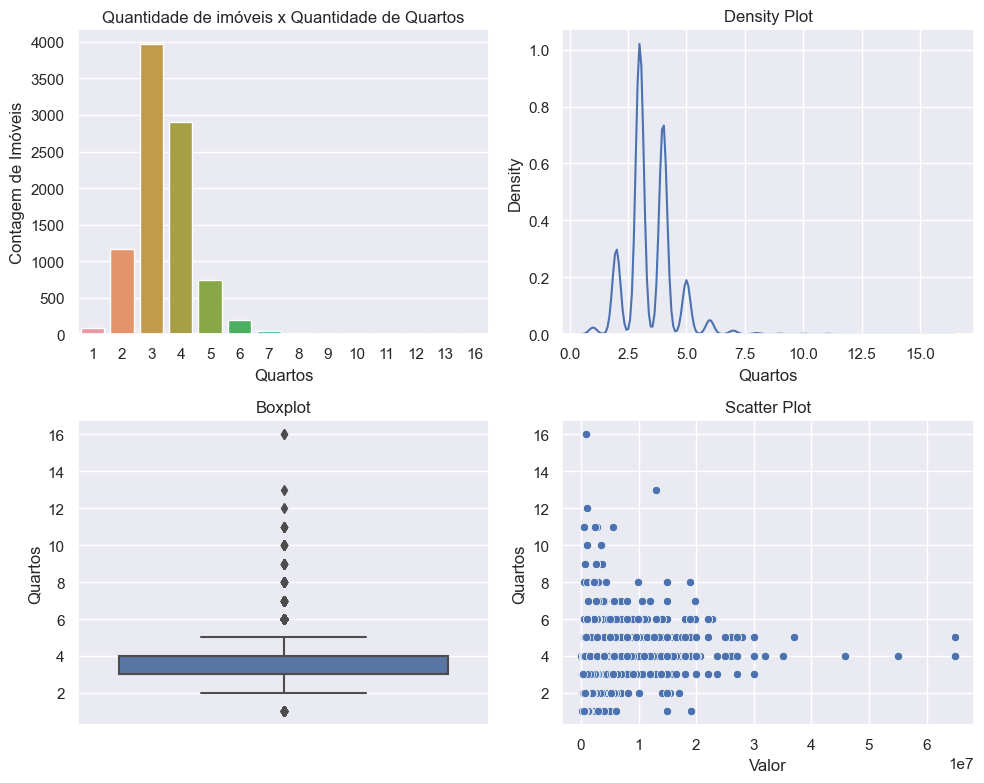

In [282]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.countplot(data=df4_imoveis, x='Quartos', ax=ax[0, 0])
ax[0, 0].set_title('Quantidade de imóveis x Quantidade de Quartos')
ax[0, 0].set_ylabel('Contagem de Imóveis')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Quartos', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Quartos', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Quartos', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Banheiros`

Imprimindo gráficos elucidativos

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.countplot(data=df4_imoveis, x='Banheiros', ax=ax[0, 0])
ax[0, 0].set_title('Quantidade de imóveis x Quantidade de banheiros')
ax[0,0].set_ylabel('Contagem de Imóveis')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Banheiros', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Banheiros', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Banheiros', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Vagas`

Imprimindo gráficos elucidativos

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.countplot(data=df4_imoveis, x='Vagas', ax=ax[0, 0])
ax[0, 0].set_title('Histograma da variável Vagas')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Vagas', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Vagas', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Vagas', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Valor`

Imprimindo gráficos elucidativos

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.histplot(data=df4_imoveis, x='Valor', ax=ax[0, 0], log_scale=True)
ax[0, 0].set_title('Histograma da variável Valor')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Valor', ax=ax[0, 1], log_scale=True)
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Valor', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Valor', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### `Valor_m2`

Imprimindo gráficos elucidativos

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.histplot(data=df4_imoveis, x='Valor_m2', ax=ax[0, 0])
ax[0, 0].set_title('Histograma da variável Valor_m2')

# Gráfico de Densidade
sns.kdeplot(data=df4_imoveis, x='Valor_m2', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df4_imoveis, y='Valor_m2', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df4_imoveis, x='Valor', y='Valor_m2', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

##### Variáveis Categóricas

##### `Rua`

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

df_rua = df4_imoveis.sort_values(by='Valor', ascending = False)

sns.barplot(data=df_rua[:10], y = 'Valor', x='Rua')
ax.set_title('Ruas com os imóveis mais caros', size=18)
ax.set_xlabel('Rua', size=12)
ax.set_ylabel('Valor (milhões de reais)', size=12)


plt.show()

##### `Bairro`

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

df_bairros = df4_imoveis.sort_values(by='Valor', ascending = False)

sns.barplot(data=df_bairros[:10], y = 'Valor', x='Bairro')
ax.set_title('Bairros com os imóveis mais caros', size=18)
ax.set_xlabel('Bairro', size=12)
ax.set_ylabel('Valor (milhões de reais)', size=12)
plt.show()

<a id="Fase-4"></a>

# FASE 4

In [ ]:
df5_imoveis = df4_imoveis.copy()
df5_imoveis

In [ ]:
df5_imoveis.sort_values(by='Bairro', ascending = False)

In [ ]:
indexes_to_drop = find_outliers_tucker(df5_imoveis['Metragem']) 
df5_imoveis.drop(indexes_to_drop, inplace=True)

indexes_to_drop = find_outliers_tucker(df5_imoveis['Quartos']) 
df5_imoveis.drop(indexes_to_drop, inplace=True)

indexes_to_drop = find_outliers_tucker(df5_imoveis['Banheiros']) 
df5_imoveis.drop(indexes_to_drop, inplace=True)

indexes_to_drop = find_outliers_tucker(df5_imoveis['Vagas']) 
df5_imoveis.drop(indexes_to_drop, inplace=True)

indexes_to_drop = find_outliers_tucker(df5_imoveis['Valor']) 
df5_imoveis.drop(indexes_to_drop, inplace=True)

indexes_to_drop = find_outliers_tucker(df5_imoveis['Valor_m2']) 
df5_imoveis.drop(indexes_to_drop, inplace=True)

In [ ]:
df5_imoveis_group = df5_imoveis[["Metragem", "Quartos", "Banheiros", "Vagas", "Valor", "Valor_m2"]]

In [ ]:
kmeans = KMeans(n_clusters=5)

In [ ]:
kmeans.fit(df5_imoveis_group)

In [ ]:
kmeans.labels_

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=df5_imoveis_group, x="Metragem", y="Valor", hue=kmeans.labels_)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=df5_imoveis_group, x="Banheiros", y="Valor", hue=kmeans.labels_)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=df5_imoveis_group, x="Quartos", y="Valor", hue=kmeans.labels_)

Após analisar as possibilidades de agrupamento usando o K-Means, iremos deixar os dados mais legíveis no relatório. Pensamos em algumas possibilidades:
- Separar os imóveis em grupos, cada grupo seria composto por um intervalo de valor por metro quadrado. Por exemplo, no grupo 1 entraria os imóveis mais caros em valor por metro quadrado, do grupo 2 ao grupo 4 entraria os imóveis com intervalos de valores à definir e no grupo 5 seriam os imóveis com o preço por metro quadrado mais barato.
- Pegar a media de valor do imóvel por bairros e agrupar os 10 mais valorizados tentando relacionar o preço e a metragem do imóvel.

<a id="Relatório"></a>

# RELATÓRIO

---

## Análise de dataset de imóveis em São Paulo

### Integrantes:

Matrícula | Nome
--- | ---
20220167322 | Gustavo Johan Vieira Vasconcelos
20220071240 | João Pedro Serpa de Souza Batista

### Introdução

Este relatório tem como principal motivação apresentar informações sobre imóveis da cidade de São Paulo.

Iremos abordar quais bairros são os mais valorizados, o que os outliers podem nos dizer sobre imóveis que estão substancialmente acima ou abaixo da média em termos de preço ou valor por metro quadrado, também identificaremos correlações como o impacto da metragem no valor do imóvel e traremos alguns imóveis que apresentam as melhores oportunidades de negócio.

### Sumário

- [Dados Usados](#Dados-Usados)
- [Pré-processamento](#Pre-processamento)
- [Gráficos](#Graficos)
- [Perguntas](#Perguntas)
- [Conclusão](#Conclusao)
- [Curiosidades](#Curiosidades)


<a id="Dados-Usados"></a>

### Dados Usados:

| Código da variável | Descrição |
| :--- | :--- |
Rua | Localização da rua de onde o imóvel pertence
Bairro | Bairro onde imóvel está localizado
Cidade | Cidade onde imóvel está localizado
Metragem | Área em metros quadrado
Quartos | Número de quartos no imóvel
Banheiros | Número de banheiros no imóvel
Vagas |  Vagas de estacionamento por veículo
Valor | Preço da casa que está em moeda brasileira BRL

Carregando **dataset de imóveis** à venda na cidade de São Paulo

In [ ]:
df_imoveis = pd.read_csv('./dados/dados_imoveis.csv')
df_imoveis.head()

In [ ]:
df_relatorio = df_imoveis.copy()
df1_relatorio = df1_imoveis.copy()

- #### Tratando as ruas com número

Após verificar os nomes das ruas, descobrimos que há algumas com números:

In [ ]:
df1_relatorio[df1_relatorio['Rua'].str.contains(',') & df1_relatorio['Rua'].notna()].sample(5)

O que poderá acarretar em distorções nos gráficos, criando variáveis diferentes para ruas iguais. Por exemplo:

In [ ]:
df1_relatorio[df1_relatorio['Rua'].str.contains('Alameda dos Anapurus') & df_relatorio['Rua'].notna()]

Como podemos observar, temos 9 ruas de mesmo nome. Se criarmos algum gráfico com um dos eixos sendo a coluna Rua, teremos 4 elementos para uma mesma rua, gerando assim dados errados.


Corrigindo os nomes da variável `Rua`

In [ ]:
df_relatorio['Rua'] = df_relatorio['Rua'].str.split(',').str[0]
df1_relatorio['Rua'] = df1_relatorio['Rua'].str.split(',').str[0]

In [ ]:
df_relatorio.loc[df_relatorio['Rua'] == 'Rua Madalena de Morais']

Nota-se que existem imóveis no dataset que são da mesma Rua e que algum deles possui o valor correto da coluna Bairro. Basta imputar-mos estes valores aos imóveis com o dado faltante, para isso iremos utilizar a função [imputa_bairro()](#Funções) definida no inicio do documento. 

In [ ]:
# removendo os valores nulos da coluna Bairro atraves da funcao imputa_bairro()
df1_relatorio['Bairro'] = df1_relatorio.apply(lambda x: x['Bairro'] if pd.notnull(x['Bairro']) \
                                else imputa_bairro(x['Rua'], df1_relatorio), axis=1)

In [ ]:
# checando novamente o número de valores nulos na coluna bairro após a primeira limpeza
df1_relatorio.isna().sum()[df1_relatorio.isna().sum() > 0]

Como restou apenas um imóvel com valor nulo na coluna 'Bairro', iremos removê-lo do dataset.

In [ ]:
# dropando o dado com valor nulo
df1_relatorio.dropna(subset=['Bairro'], inplace=True)

# checando novamente a quantiadde de valores nulos
print(f'Total de valores nulos na coluna Bairro = {df1_relatorio["Bairro"].isna().sum()}')

Restaram agora apenas as ruas com valores nulos, uma das soluções para imputar a variável Rua seria obter uma Rua aleatória do mesmo bairro do dado em questão, outra solução seria simplesmente deletar todos os dados com valores de Rua faltante.

Após analisar o resultado da nossa atribuição de ruas, vimos que, examinando as ruas dos imóveis no Google Maps, algumas não condiziam com os dados dos imóveis, seja em tamanho do imóvel ou em valor. Gerando assim, resultados totalmente diferentes e imprecisos na montagem dos gráficos.

Como não queríamos perder cerca de 35% dos dados decidimos manter os imóveis que tinham a rua como valor nulo e focar nossa análise a partir dos bairros.

<a id="Pre-processamento"></a>

### Pré-processamento:

- #### Adicionando nova coluna

In [ ]:
# Já mostrado na fase 2, apenas adicionando ao dataframe do relatório

df1_relatorio['Valor_m2'] = df1_relatorio['Valor'] / df1_relatorio['Metragem']

- #### Fazendo ajustes adicionais

Descobrimos que no dataset havia na coluna 'Bairro' os valores Jardim Europa, Jardim Paulista, Jardim Paulistano, Jardim América e Jardins. Porém os quatro primeiros formam a Região dos Jardins, como não sabemos de qual bairro são os imóveis que estão em Jardins decidimos alterar o nome dos quatro primeiros para Jardins.

In [ ]:
df1_relatorio[df1_relatorio['Bairro'].str.contains('Jardim América') 
            | df1_relatorio['Bairro'].str.contains('Jardim Europa')
            | df1_relatorio['Bairro'].str.contains('Jardim Paulista')
            | df1_relatorio['Bairro'].str.contains('Jardim América')]

df1_relatorio['Bairro'] = df1_relatorio['Bairro'].replace({'Jardim Europa': 'Jardins', 'Jardim Paulista': 'Jardins',
                                           'Jardim Paulistano': 'Jardins', 'Jardim América': 'Jardins'})

df1_relatorio[df1_relatorio['Bairro'].str.contains('Jardins')]

Feita a alteração descobrimos um imóvel no dataframe acima, com valor errado, possívelmente são valores de aluguel que conseguiu "escapar" da remoção dos imóveis para alugar feita anteriormente.

In [ ]:
# Verificando se existem imóveis nas mesmas condições
df1_relatorio[df1_relatorio['Valor'] < 100000]


- #### Removendo imóveis desproporcionais

Consideramos os imóveis acima com valores desproporcionais, isso fez com que verificássemos se haviam outros imóveis nas mesmas condições, com isso adiantamos a remoção de alguns outliers que será feita na sua totalidade posteriormente.

Verificando as Vagas:

In [ ]:
# Verifica imoveis com vagas maiores ou iguais a 30 e remove-os

df1_relatorio[df1_relatorio['Vagas'] >= 30]

Verificando a Metragem:

In [ ]:
df1_relatorio[(df1_relatorio['Metragem'] >= 35000)]

Verificando esses 3 imóveis no Google Maps, o único que justifica a metragem é o [primeiro](https://www.google.com/maps/place/R.+Benedito+Felizardo+-+S%C3%ADtio+Represa,+S%C3%A3o+Paulo+-+SP,+04894-050/@-23.859371,-46.7590753,596m/data=!3m1!1e3!4m6!3m5!1s0x94ce35f780d51817:0xe34c80ddc522663!8m2!3d-23.8594419!4d-46.7579088!16s%2Fg%2F1ymywlvwk?entry=ttu), que está localizado em um bairro de chácaras.

Verificando a rua do terceiro no [Google Maps](https://www.google.com/maps/@-23.5821794,-46.7074039,844m/data=!3m1!1e3?entry=ttu) não há nenhum imóvel que justifique os 750000 metros quadrados, o mesmo se aplica ao segundo imóvel, sendo assim, optamos por excluí-los do dataset.

In [ ]:
df1_relatorio[(df1_relatorio['Metragem'] <= 50) & (df1_relatorio['Quartos'] >= 3)]

Verificando os Quartos:

Nesta seção iremos procurar imóveis que possuem valores fora da realidade para imóveis com uma quantidade definida de quartos.

Iremos comparar principalmente a quantidade de quartos e a metragem do imóvel.

In [ ]:
df1_relatorio[(df1_relatorio['Quartos'] >= 10) & (df1_relatorio['Valor'] <= 1000000) & (df1_relatorio['Metragem'] <= 400)]

In [ ]:
df1_relatorio[(df1_relatorio['Quartos'] >= 10) & (df1_relatorio['Metragem'] <= 300)]

Verificando os Banheiros:

In [ ]:
df1_relatorio[df1_relatorio['Banheiros'] >= 15]

Verificando as Vagas:

In [ ]:
df1_relatorio[(df1_relatorio['Vagas'] >= 20)]

Se observarmos as tabelas acima vemos que alguns imóveis possuem exatamente os mesmos valores. Consideramos que esses imóveis estão duplicados e iremos removê-los.

Analisando-as com atenção, temos outros imóveis que a única diferença entre os duplicados e eles é um acréscimo de exatamente 5 metros quadrados na Metragem. 

Consideramos assim que são os mesmos que estão duplicados. Por fim, removeremos além dos duplicados os que possuem este acréscimo.

In [ ]:
df2_relatorio = df1_relatorio.copy()

In [ ]:
df2_relatorio.drop_duplicates(subset=df2_relatorio.columns.difference(['Metragem', 'Valor_m2']), inplace=True)

In [ ]:
# Removido os duplicados, antes de remover os que consideramos irreais, iremos salvar alguns casos curiosos que identificamos no dataset
df_curiosos = pd.DataFrame(columns=df2_relatorio.columns)

df_curiosos = df_curiosos.append(df2_relatorio[df2_relatorio['Valor'] < 100000])
df_curiosos = df_curiosos.append(df2_relatorio[df2_relatorio['Metragem'] == 750000])
df_curiosos = df_curiosos.append(df2_relatorio[(df2_relatorio['Metragem'] <= 50) & (df2_relatorio['Quartos'] >= 3)])
df_curiosos = df_curiosos.append(df2_relatorio[df2_relatorio['Banheiros'] > 16])
df_curiosos

Deletando os imóveis considerados desproporcionais:

In [ ]:
df2_relatorio.drop(df2_relatorio[df2_relatorio['Valor'] <= 15000].index, inplace=True)

df2_relatorio.drop(df2_relatorio[df2_relatorio['Vagas'] >= 30].index, inplace = True)

df2_relatorio.drop(df2_relatorio[(df2_relatorio['Metragem'] == 35677) | (df2_relatorio['Metragem'] == 750000)].index, inplace = True)

df2_relatorio.drop(df2_relatorio[(df2_relatorio['Quartos'] >= 10) & (df2_relatorio['Valor'] <= 1000000) & (df2_relatorio['Metragem'] <= 400)].index, inplace = True)

df2_relatorio.drop(df2_relatorio[(df2_relatorio['Quartos'] >= 10) & (df2_relatorio['Metragem'] <= 300)].index, inplace = True)

df2_relatorio.drop(df2_relatorio[df2_relatorio['Banheiros'] >= 15].index, inplace = True)

df2_relatorio.drop(df2_relatorio[(df2_relatorio['Metragem'] <= 50) & (df2_relatorio['Quartos'] >= 3)].index, inplace = True)

- #### Removendo os outliers

Como visto na fase 3, temos outliers que estão distorcendo os gráficos, a função [find_outliers_tucker()](#Funções) remove-os fazendo com que os gráficos fiquem proporcionais e legíveis

In [ ]:
# Removendo outliers na coluna Metragem

indexes_of_outliers = find_outliers_tucker(df2_relatorio['Metragem'])
df2_relatorio = df2_relatorio.drop(indexes_of_outliers)

# Removendo outliers na coluna Quartos

indexes_of_outliers = find_outliers_tucker(df2_relatorio['Quartos'])
df2_relatorio = df2_relatorio.drop(indexes_of_outliers)

# Removendo outliers na coluna Banheiros

indexes_of_outliers = find_outliers_tucker(df2_relatorio['Banheiros'])
df2_relatorio = df2_relatorio.drop(indexes_of_outliers)

# Removendo outliers na coluna Vagas

indexes_of_outliers = find_outliers_tucker(df2_relatorio['Vagas'])
df2_relatorio = df2_relatorio.drop(indexes_of_outliers)

# Removendo outliers na coluna Valor

indexes_of_outliers = find_outliers_tucker(df2_relatorio['Valor'])
df2_relatorio = df2_relatorio.drop(indexes_of_outliers)

# Removendo outliers na coluna Valor_m2

indexes_of_outliers = find_outliers_tucker(df2_relatorio['Valor_m2'])
df2_relatorio = df2_relatorio.drop(indexes_of_outliers)

<a id="Graficos"></a>

### Gráficos

- #### Boxplots

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))

# Boxplot da variável Metragem
sns.boxplot(data=df2_relatorio, y='Metragem', ax=ax[0, 0])
ax[0, 0].set_title('Boxplot da variável Metragem')

# Boxplot da variável Quartos
sns.boxplot(data=df2_relatorio, y='Quartos', ax=ax[0, 1])
ax[0, 1].set_title('Boxplot da variável Quartos')

# Boxplot da variável Banheiros
sns.boxplot(data=df2_relatorio, y='Banheiros', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot da variável Banheiros')

# Boxplot da variável Vagas
sns.boxplot(data=df2_relatorio, y='Vagas', ax=ax[1, 1])
ax[1, 1].set_title('Boxplot da variável Vagas')

# Boxplot da variável Valor
sns.boxplot(data=df2_relatorio, y='Valor', ax=ax[2, 0])
ax[2, 0].set_title('Boxplot da variável Valor')

# Boxplot da variável Valor_m2
sns.boxplot(data=df2_relatorio, y='Valor_m2', ax=ax[2, 1])
ax[2, 1].set_title('Boxplot da variável Valor_m2')

plt.tight_layout()

plt.show()

- #### Analisando as variáveis numéricas

`Metragem`

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Histograma
sns.histplot(data=df2_relatorio, x='Metragem', ax=ax[0, 0])#, kde = True, log_scale = True, bins = 25)
ax[0, 0].set_title('Histograma da variável Metragem')

# Gráfico de Densidade
sns.kdeplot(data=df2_relatorio, x='Metragem', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df2_relatorio, y='Metragem', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df2_relatorio, y='Valor', x='Metragem', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

In [ ]:
# Gráfico de Regressão 
fig, ax = plt.subplots(figsize=(10, 8))
sns.regplot(data=df2_relatorio, y='Valor', x='Metragem', marker='.',color='.3', line_kws=dict(color="r"))
ax.set_title('Gráfico de Regressão Linear')

plt.tight_layout()
plt.show()

`Quartos`

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Gráficos de Contagem

sns.countplot(data=df2_relatorio, x='Quartos', ax=ax[0])
ax[0].set_title('Quantidade de imóveis x Quantidade de Quartos', size = 20)
ax[0].set_ylabel('Contagem de Imóveis')

sns.countplot(data=df1_relatorio[(df1_relatorio['Quartos'] > 5)], x='Quartos', ax=ax[1])
ax[1].set_title('Quantidade de imóveis x Quantidade de Quartos (a partir de 6 quartos)', size = 20)
ax[1].set_ylabel('Contagem de Imóveis')


plt.tight_layout()

plt.show()

In [ ]:
# Gráfico de Boxplot
fig, ax = plt.subplots(figsize=(5, 4))

sns.boxplot(data=df1_relatorio, y='Quartos')
ax.set_title('Boxplot')

plt.tight_layout()

plt.show()


`Banheiros`

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Gráficos de Contagem
sns.countplot(data=df2_relatorio[(df2_relatorio['Banheiros'] >= 1) & (df1_relatorio['Banheiros'] <= 5)], x='Banheiros', ax=ax[0])
ax[0].set_title('Quantidade de imóveis x Quantidade de Banheiros', size = 20)
ax[0].set_ylabel('Contagem de Imóveis')

sns.countplot(data=df2_relatorio[(df2_relatorio['Banheiros'] >= 6) & (df1_relatorio['Banheiros'] <= 9)], x='Banheiros', ax=ax[1])
ax[1].set_title('Quantidade de imóveis x Quantidade de Banheiros (entre 6 e 9 banheiros)', size = 20)
ax[1].set_ylabel('Contagem de Imóveis')


plt.tight_layout()

plt.show()

In [ ]:
# Gráfico de Boxplot
fig, ax = plt.subplots(figsize=(5, 4))

sns.boxplot(data=df2_relatorio, y='Banheiros')
ax.set_title('Boxplot')

plt.tight_layout()

plt.show()


`Vagas`

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico de Contagem
sns.countplot(data=df2_relatorio, x='Vagas', ax=ax[0, 0])
ax[0, 0].set_title('Quantidade de imóveis x Quantidade de Vagas')

# Gráfico de Densidade
sns.kdeplot(data=df2_relatorio, x='Vagas', ax=ax[0, 1])
ax[0, 1].set_title('Density Plot')

# Gráfico de Boxplot
sns.boxplot(data=df2_relatorio, y='Vagas', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot')

# Gráfico de Scatter Plot
sns.scatterplot(data=df2_relatorio, x='Valor', y='Vagas', ax=ax[1, 1])
ax[1, 1].set_title('Scatter Plot')

plt.tight_layout()

plt.show()

`Valor`

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Gráfico de Histograma
sns.histplot(data=df2_relatorio, x='Valor', ax=ax[0], kde=True)
ax[0].set_title('Histograma da variável Valor')

# Gráfico de Boxplot
sns.boxplot(data=df2_relatorio, y='Valor', ax=ax[1])
ax[1].set_title('Boxplot')


plt.tight_layout()

plt.show()

`Valor_m2`

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Gráfico de Histograma

sns.histplot(data=df2_relatorio, x='Valor_m2', ax=ax[0], kde=True)
ax[0].set_title('Histograma da variável Valor_m2')

# Gráfico de Boxplot
sns.boxplot(data=df2_relatorio, y='Valor_m2', ax=ax[1])
ax[1].set_title('Boxplot')

plt.tight_layout()

plt.show()

- #### Analisando as variáveis categóricas

`Rua`

In [ ]:
# Esses 2 imóveis foram removidos, o primeiro estava com erro de digitação não sendo possível identificar o nome
# Já no segundo o nome da rua se referia à um nome de uma praça

df1_relatorio.drop(2906, inplace=True)
df1_relatorio.drop(1530, inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

df_rua = df1_relatorio.sort_values(by='Valor', ascending = False)

sns.barplot(data = df_rua[:25], x = 'Valor', y='Rua')
ax.set_title('Ruas com os imóveis mais caros', size=18)
ax.set_ylabel('Rua', size=12)
ax.set_xlabel('Valor (milhões de reais)', size=12)

plt.tight_layout()

plt.show()

`Bairro`

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

df_bairros = df1_relatorio.sort_values(by='Valor', ascending = False)

sns.barplot(data=df_bairros[:80], x = 'Valor', y='Bairro')
ax.set_title('Bairros com os imóveis mais caros', size=18)
ax.set_ylabel('Bairro', size=12)
ax.set_xlabel('Valor (milhões de reais)', size=12)

plt.tight_layout()

plt.show()

<a id="Perguntas"></a>

### Perguntas

Utilizaremos o `df2_relatorio` por estar com os dados mais tratados, tentamos responder as perguntas utilizando o `df1_relatório` que está menos tratado, porém, como foi observado anteriormente haviam muitos dados que não tinham lógica concreta na existência, consequentemente não obtivemos resultados condizentes com a realidade. Optamos então, sacrificar alguns imóveis para obter dados mais próximos do real possível.

In [ ]:
df3_relatorio = df2_relatorio.copy()

 1) **Quais os bairros onde os imóveis são mais valorizados, na média?**

In [ ]:
df_p1 = df3_relatorio.groupby('Bairro').agg({'Valor': 'mean'}).sort_values(by='Valor', ascending=False)\
    .reset_index()
df_p2 = df3_relatorio.groupby('Bairro').agg({'Valor': 'median'}).sort_values(by='Valor', ascending=False)\
    .reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))

sns.barplot(data=df_p1[:10], x='Bairro', y='Valor', ax=ax)
ax.set_title('Bairros por Valor Médio', size=28)
ax.set_ylabel('Preço médio (milhões de reais)', size=22)
ax.set_xlabel('Bairro', size=22)

plt.tight_layout()

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))

sns.barplot(data=df_p2[:10], x='Bairro', y='Valor', ax=ax)
ax.set_title('Bairros por Valor Mediano', size=28)
ax.set_ylabel('Preço mediano (milhões de reais)', size=22)
ax.set_xlabel('Bairro', size=22)

plt.tight_layout()

plt.show()

2) **Qual o preço médio do m2 nos bairros mais valorizados?**

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))

df_preco_m2 = df3_relatorio.groupby('Bairro').agg({'Valor': 'mean', 'Valor_m2':'mean'}).sort_values(by='Valor', ascending=False)\
    .reset_index()[:10]

del df_preco_m2['Valor']

df_preco_m2_sorted = df_preco_m2.sort_values(by='Valor_m2', ascending=False)

sns.barplot(data=df_preco_m2_sorted, x = 'Bairro', y = 'Valor_m2')
ax.set_title('Preço médio do m2 por bairro', size=28)
ax.set_ylabel('Preço médio do m2', size=22)
ax.set_xlabel('Bairro', size=22)

plt.tight_layout()

plt.show()

3) **Cerca de 80% dos imóveis estão abaixo dos R$ 2.000.000,00?**

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))

df_p3 = df3_relatorio.reset_index()
total_imoveis = df_p3.shape[0]

sns.barplot(y = [((df_p3[df_p3['Valor'] < 2000000].shape[0]) / total_imoveis) * 100, ((df_p3[df_p3['Valor'] >= 2000000].shape[0]) / total_imoveis) * 100], x = ['Abaixo de 2 Milhões','Acima de 2 Milhões'])
ax.set_title('Porcentagem de Imóveis Abaixo e Acima de R$ 2.000.000,00', size = 28)
ax.set_ylabel('Porcentagem', size = 22)
ax.set_xlabel('Imóveis',size = 22)

plt.tight_layout()

plt.show()


Errado, como podemos ver no gráfico acima, os imóveis abaixo de 2 milhões correspondem à um pouco mais de 60% do total de imóveis no dataset.

4) **A coluna metragem possui um valor de correlação de Pearson forte com o preço do imóvel (pelo menos 0.6)?**

**VERDADEIRO**. A correlação entre `Metragem` e `Valor` é de 0.79, sendo acima de 0.6 e considerada FORTE.

In [ ]:
correlation = df3_relatorio.corr( method='pearson' )
sns.heatmap( correlation, cmap='mako', annot=True );

Ao visualizar o gráfico acima nota-se o valor de 0.79 como a correlação entre as colunas `Valor` e `Metragem`, este valor de 0.79 é acima do limite estabelecido de 0.6 e também é considerado um valor classificado como FORTE para correlação entre duas variáveis numéricas. Portanto a nossa pergunta foi validada como VERDADEIRA.

5. **Para cada unidade acrescida na quantidade de 'Quartos', o preço médio dos imóveis aumenta em 10%?**

**ERRADO**.

In [ ]:
df_p6 = df3_relatorio.groupby('Quartos').agg({"Valor": "mean"}).reset_index()
df_p6.sort_values(by='Valor').head(10)

In [ ]:
media_por_quarto = df_p6['Valor'].pct_change() * 100
media_por_quarto

In [ ]:
print(f"O aumento percentual médio no preço do Imóvel ao acrescentar um Quarto foi de {media_por_quarto.mean():.2f}% na média.")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(x=['2-2', '2-3', '3-4', '4-5'], y=media_por_quarto, ax=ax)
ax.set_title('Aumento percentual médio no preço do Imóvel por quantidade de Quartos')
ax.set_xlabel('De X para Y Quartos')
ax.set_ylabel('Aumento percentual médio (%)')

plt.show()

<a id="Conclusao"></a>

### Conclusões

Com base na análise dos dados dos imóveis, podemos tirar as seguintes conclusões:

**Distribuição de Valores:** A maioria dos imóveis nesse dataset está concentrada em faixas de valor até R\$ 2.000.000,00. Com aproximadamente 63\% dos imóveis custando menos de R\\$ 2.000.000,00.

**Localização:** Imóveis localizados em determinados bairros ou áreas urbanas têm um valor médio significativamente mais alto em comparação com outras regiões. Verificando no maps, os bairros que possuem o preço médio por metro quadrado mais altos, estão relativamente próximos à Avenida Paulista.

**Correlações:** Existem correlações positivas consideradas moderadas entre a metragem dos imóveis x (número de quartos, número de banheiros e número de vagas). E uma correlação forte entre o valor e a metragem dos imóveis. No primeiro caso, quanto maior o número de quartos, banheiros ou vagas, a metragem do imóvel tende a aumentar. No segundo caso, quanto na medida que metragem aumenta o valor do imóvel também aumenta.

**Aumento no número de aposentos:** Vimos que para uma pessoa que esteja em dúvida entre adquirir um imóvel com 2 quartos ou um imóvel com 3 quartos, terá que desembolsar praticamente o dobro do valor do imóvel de 2 quartos.



<a id="Curiosidades"></a>

### Curiosidades

Encontramos no dataset alguns imóveis com valores curiosos:

- Dois imóveis localizados em 2 dos bairros mais valorizados de São Paulo com preços atraentes

In [ ]:
df_curiosos[df_curiosos['Valor'] < 16000]

- Três imóveis com a metragem totalmente incompatível com a quantidade de quartos e banheiros:

In [ ]:
df_curiosos[(df_curiosos['Metragem'] <= 37)]

- Um imóvel com 40 banheiros

In [ ]:
df_curiosos[(df_curiosos['Banheiros'] == 40)]

- Um imóvel cuja metragem é aproximadamente o tamanho da metade da área total do bairro que se encontra

In [ ]:
df_curiosos[(df_curiosos['Metragem'] > 500)]

<img src="jardimguedala.png" alt="Minha imagem de exemplo" width="800" height="480">